In [1]:
%matplotlib inline
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sb
import xarray as xr
import os.path as path
import matplotlib.pyplot as plt
from aux.ml_flood_config import path_to_data
from aux.utils import calc_stat_moments
from aux.utils import open_data
from aux.plot import Map
import seaborn as sns

from dask.distributed import Client
client = Client(processes=True)
import dask
#dask.config.set(scheduler='processes')
from dask.diagnostics import ProgressBar

/home/srvx11/lehre/users/a1303583/.conda/envs/ml_flood/lib/python3.7/site-packages/distributed/dashboard/core.py:74: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [2]:
# load dask client
client
# define some vars
data_path = f'{path_to_data}danube/'
print(data_path)

/home/srvx11/lehre/users/a1303583/ipython/ml_flood/data/danube/


## Calculate various statistical measures across the data and create plots

In [ ]:
era5 = open_data(data_path, kw='era5')
glofas = open_data(data_path, kw='glofas_ra')

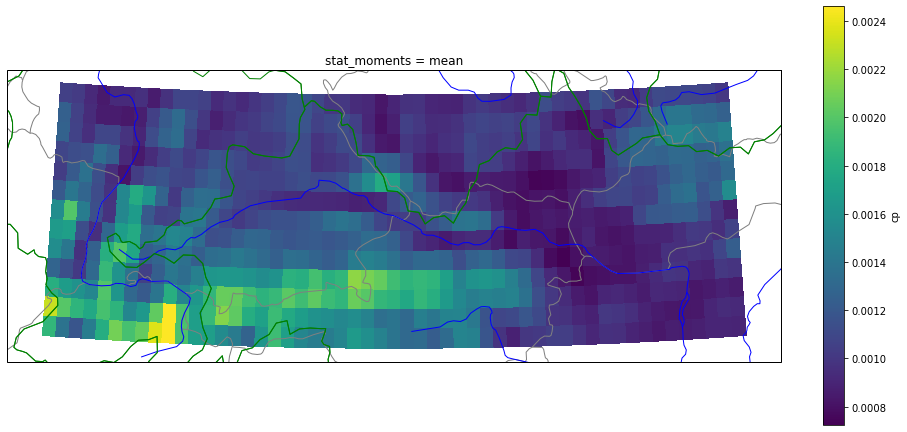

In [4]:
sm = calc_stat_moments(era5, dim_aggregator='time', time_constraint=None)
m = Map(figure_kws=dict(figsize=(15,10)))



da_mean = sm['cp'].sel(stat_moments='mean').compute()
#print(da_mean)
#print(da_std)
m.plot(da_mean)
plt.show()

(<Figure size 1080x720 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f24ed46b048>)

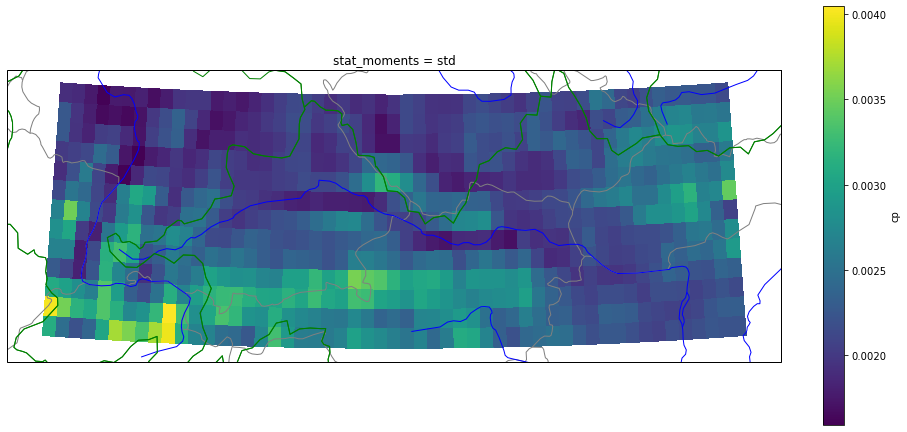

In [5]:
da_std = sm['cp'].sel(stat_moments='std').compute()
m.plot(da_std)

In [62]:
def plot_ts(da, key):
    """Plot a times series for a given xarray dataarray.
    """
    p = sns.lineplot(data=da.to_pandas(), linewidth=2)
    p.set_xlabel('time')
    p.set_ylabel(key)

In [63]:
sm = calc_stat_moments(era5, dim_aggregator='spatial', time_constraint=None)

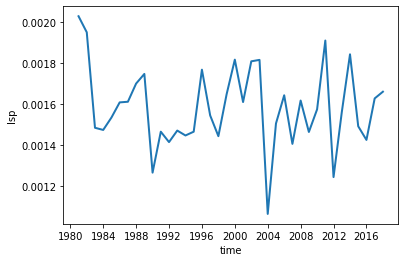

In [64]:
key = 'lsp'
da = sm[key].sel(stat_moments='mean')
da = da.resample(time="y").mean()

plot_ts(da=da, key='lsp')
plt.show()

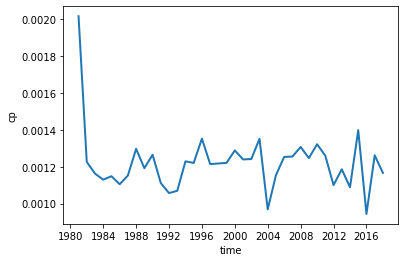

In [65]:
key = 'cp'
da = sm[key].sel(stat_moments='mean')
da = da.resample(time="y").mean()

plot_ts(da=da, key='cp')
plt.show()

/home/srvx11/lehre/users/a1303583/.conda/envs/py3/lib/python3.7/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


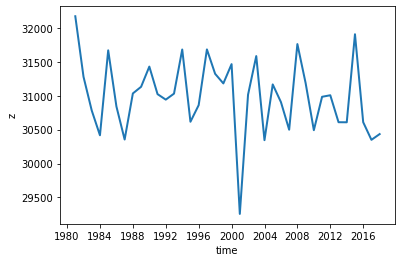

In [66]:
key = 'z'
da = sm[key].sel(stat_moments='mean')
da = da.resample(time="y").mean()

plot_ts(da=da, key='z')
plt.show()

## Investigate a local region (Krems) for the time: May-June 2013

In [171]:
krems = dict(latitude=48.403, longitude=15.615)
local = dict(latitude=slice(krems['latitude']+1,krems['latitude']-1),
             longitude=slice(krems['longitude']-1, krems['longitude']+1))

In [172]:
#era5 = era5.interp(latitude=glofas.latitude, longitude=glofas.longitude)
start_date = '2013-05-20'
end_date = '2013-06-05'
xds = era5.sel(local).sel(time=slice(start_date, end_date))

glofas = glofas.sel(time=slice(start_date, end_date))
y = glofas.interp(krems)
ydf = y.drop(['latitude', 'longitude']).to_dataframe()
print(xds)
print(ydf)

<xarray.Dataset>
Dimensions:    (latitude: 8, level: 3, longitude: 8, time: 17)
Coordinates:
  * time       (time) datetime64[ns] 2013-05-20 2013-05-21 ... 2013-06-05
  * latitude   (latitude) float32 49.25 49.0 48.75 48.5 48.25 48.0 47.75 47.5
  * longitude  (longitude) float32 14.75 15.0 15.25 15.5 15.75 16.0 16.25 16.5
  * level      (level) float64 850.0 700.0 500.0
Data variables:
    cp         (time, latitude, longitude) float32 dask.array<shape=(17, 8, 8), chunksize=(17, 8, 8)>
    tp         (time, latitude, longitude) float32 dask.array<shape=(17, 8, 8), chunksize=(17, 8, 8)>
    lsp        (time, latitude, longitude) float32 dask.array<shape=(17, 8, 8), chunksize=(17, 8, 8)>
    z          (time, level, latitude, longitude) float32 dask.array<shape=(17, 3, 8, 8), chunksize=(17, 3, 8, 8)>
    t          (time, level, latitude, longitude) float32 dask.array<shape=(17, 3, 8, 8), chunksize=(17, 3, 8, 8)>
    q          (time, level, latitude, longitude) float32 dask.array<shape=

In [173]:
#print([era5[i] for i in era5.keys()])

#### generate day to day changes with diff

In [174]:
ydf_change = ydf.dis.diff(1)
#print(ydf_change)

#### calculate pearson corrcoefs between dis and each era5 point for t and up to t-8

In [211]:
def corrs(da, y):
    crs = xr.DataArray(np.zeros([da.latitude.values.shape[0], da.longitude.values.shape[0]]),
                       coords=[da.latitude, da.longitude], dims=['latitude', 'longitude'])
    for lat in da.latitude:
        for lon in da.longitude:
            df_iter = da.sel(latitude=lat, longitude=lon).to_series().drop(columns=['latitude', 'longitude'])
            cr = df_iter.corr(y)
            crs.loc[dict(latitude=lat.values, longitude=lon.values)] = cr
    crs.name = 'correlations'
    return crs

In [270]:
def corrs_fast(da, y):
    crs = xr.DataArray(np.zeros([da.latitude.values.shape[0], da.longitude.values.shape[0]]),
                       coords=[da.latitude, da.longitude], dims=['latitude', 'longitude'])
    
    x_anom = da.sel(time=y.time.values)-da.sel(time=y.time.values).mean('time')
    y_anom = y-y.mean('time')
    x_std = x_anom.std()
    y_std = y_anom.std()
    crs = x_anom.dot(y_anom)/(x_std*y_std)
    print(crs.values)
    crs.name = 'correlations'
    return crs

#### plot corrcoefs on spatial map

In [272]:
def map3x3(ds, y, var, corr_data=False, plot_kw=False, point=None):
    fig, axes = plt.subplots(3, 3, figsize=(15,15), sharex='col', sharey='row')
    fig.subplots_adjust(hspace=0.35, wspace=0.25)
    
    plt.suptitle(f'correlation gridpoint to river point; variable={var}')
    i = 0
    for axrow in axes:
        axrow[0].set_ylabel('latitude')
        for axcol in axrow:
            axcol.set_title(f't-{i}')
            if not corr_data:
                da = xds[var].shift(time=i)
                crs = corrs(da, y)
                crs.to_netcdf(f'save/crs_{var}_shift_{i}.nc')
                #da = xds[var].shift(time=i)
                #crs = corrs_fast(da, y)
            elif corr_data:
                crs = ds
            if plot_kw:
                if corr_data:
                    crs['correlations'].isel(time_delay=i).plot.imshow(ax=axcol, vmin=-1, vmax=1, cmap='coolwarm_r')
                else:
                    crs.plot.imshow(ax=axcol, vmin=-1, vmax=1, cmap='coolwarm_r')
                axcol.set_title(f't-{i}')
                axcol.plot(point['longitude'], point['latitude'], color='cyan',
                           marker='o', markersize=20, mew=4, markerfacecolor='none')
            i += 1
    return None

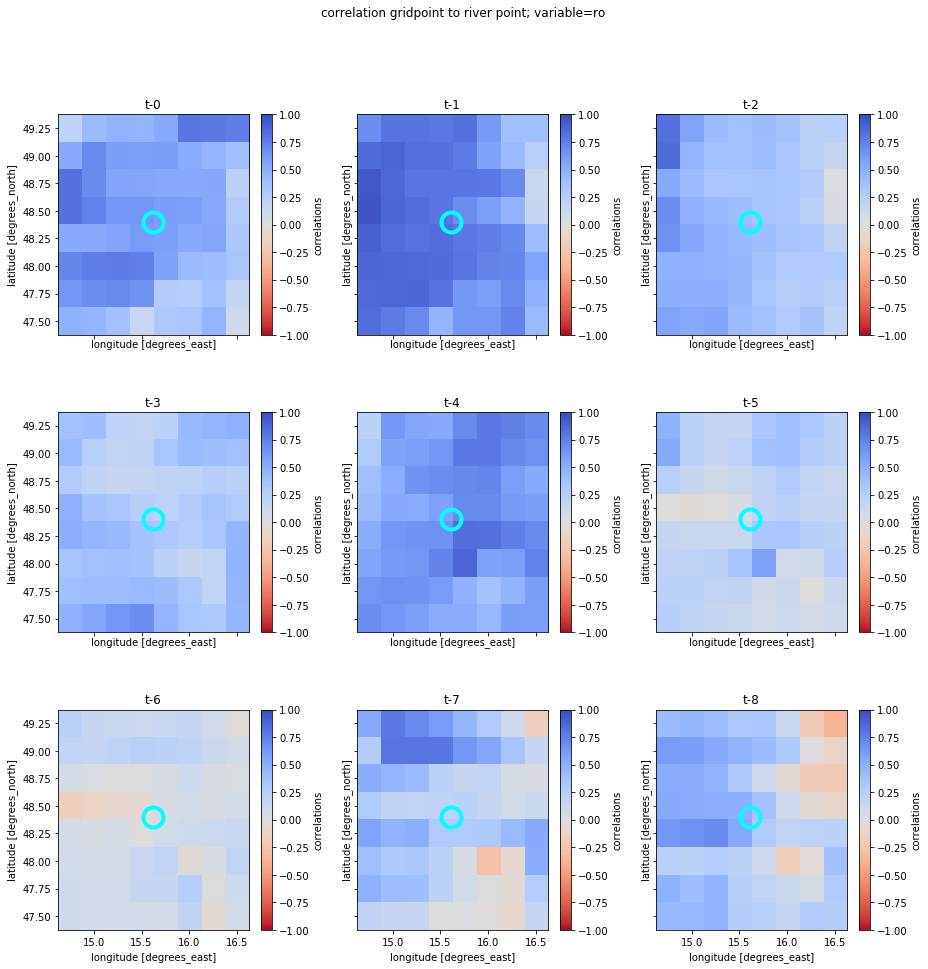

In [273]:
#crs_data = xr.open_mfdataset('/home/srvx11/lehre/users/a1303583/ipython/ml_flood/python/save/*crs_lsp*', concat_dim='time_delay')
#print(crs_data)

#print(xds)

map3x3(xds, ydf_change, 'ro', corr_data=False, plot_kw=True, point=krems)
#map3x3(xds, y['dis'].diff('time', 1), 'lsp', corr_data=False, plot_kw=True, point=krems)
#map3x3(crs_data, ydf_change, 'lsp', corr_data=True, plot_kw=True, point=krems)

AttributeError: 'Dataset' object has no attribute 'plot'

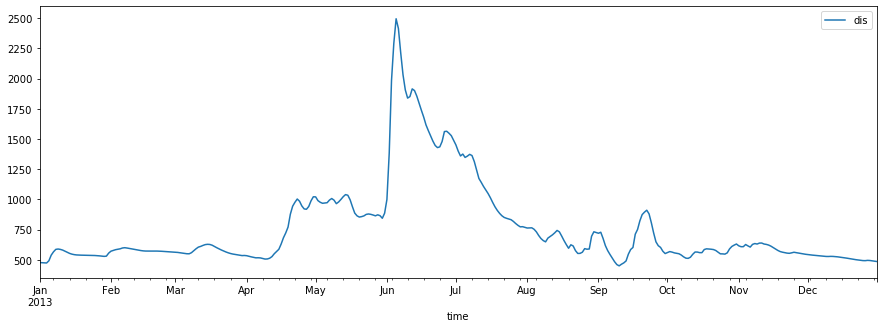

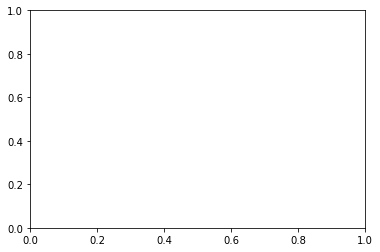

In [14]:
ydf.plot(y='dis', figsize=(15,5))
fig, ax = plt.subplots()
xdf.plot(y=['lsp', 'cp'], ax=ax, figsize=(15,5))

In [ ]:
xdf.cumsum().plot(y=['lsp', 'cp'], figsize=(15,5))

In [ ]:
sns.jointplot(x='cp', y='dis', data=merge, kind='hex')